# Estimating archaic TMRCAs from the real data

In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.0
✔ tibble  2.1.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr
Warning message:
“no function found corresponding to methods exports from ‘GenomicRanges’ for: ‘concatenateObjects’”

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.975)

In [3]:
tafr <- calculate_tafr(highcov_gt)

In [4]:
tafr %>% filter(afr == "a00") %>% unnest(counts_afr) %>% group_by(afr) %>% summarise_if(is.numeric, mean)

afr,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,age,a,b,c,d,e,f,total
a00,265532.1,286552.9,244511.3,7.122598e-10,45000,959.2308,0.1538462,7.384615,193.5385,11.84615,983.1538,5669202


In [5]:
tmrca_full %<-%
    map_dfr(c("den8", "den4", "mez2", "spy1", "shotgun_mez2", "shotgun_spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "full", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [19]:
tmrca_lippold %<-%
    map_dfr(c("elsidron2", "den8", "den4", "mez2", "spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "lippold", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [20]:
tmrca_exome %<-%
    map_dfr(c("elsidron1", "den8", "den4", "mez2", "spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "exome", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [21]:
tmrca_full %<>% mutate(capture = "full")
tmrca_lippold %<>% mutate(capture = "lippold")
tmrca_exome %<>% mutate(capture = "exome")

In [22]:
tmrca_df <- bind_rows(tmrca_full, tmrca_lippold, tmrca_exome)

In [25]:
saveRDS(tmrca_df, here("data/rds/tmrca3.rds"))

In [31]:
tmrca_df %>% filter(sites == "tv_only", arch == "mez2", capture == "full", dp == 3, afr == "a00") %>%
unnest(counts_arch) %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,dp,a,b,c,d,e,f,total
mez2,349422.9,1.429,265532.1,286552.9,244511.3,7.122598e-10,3,205,10.69231,13.23077,450.5385,505.3077,493.7692,4429566


In [9]:
tmrca_df <- readRDS(here("data/rds/tmrca2.rds"))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


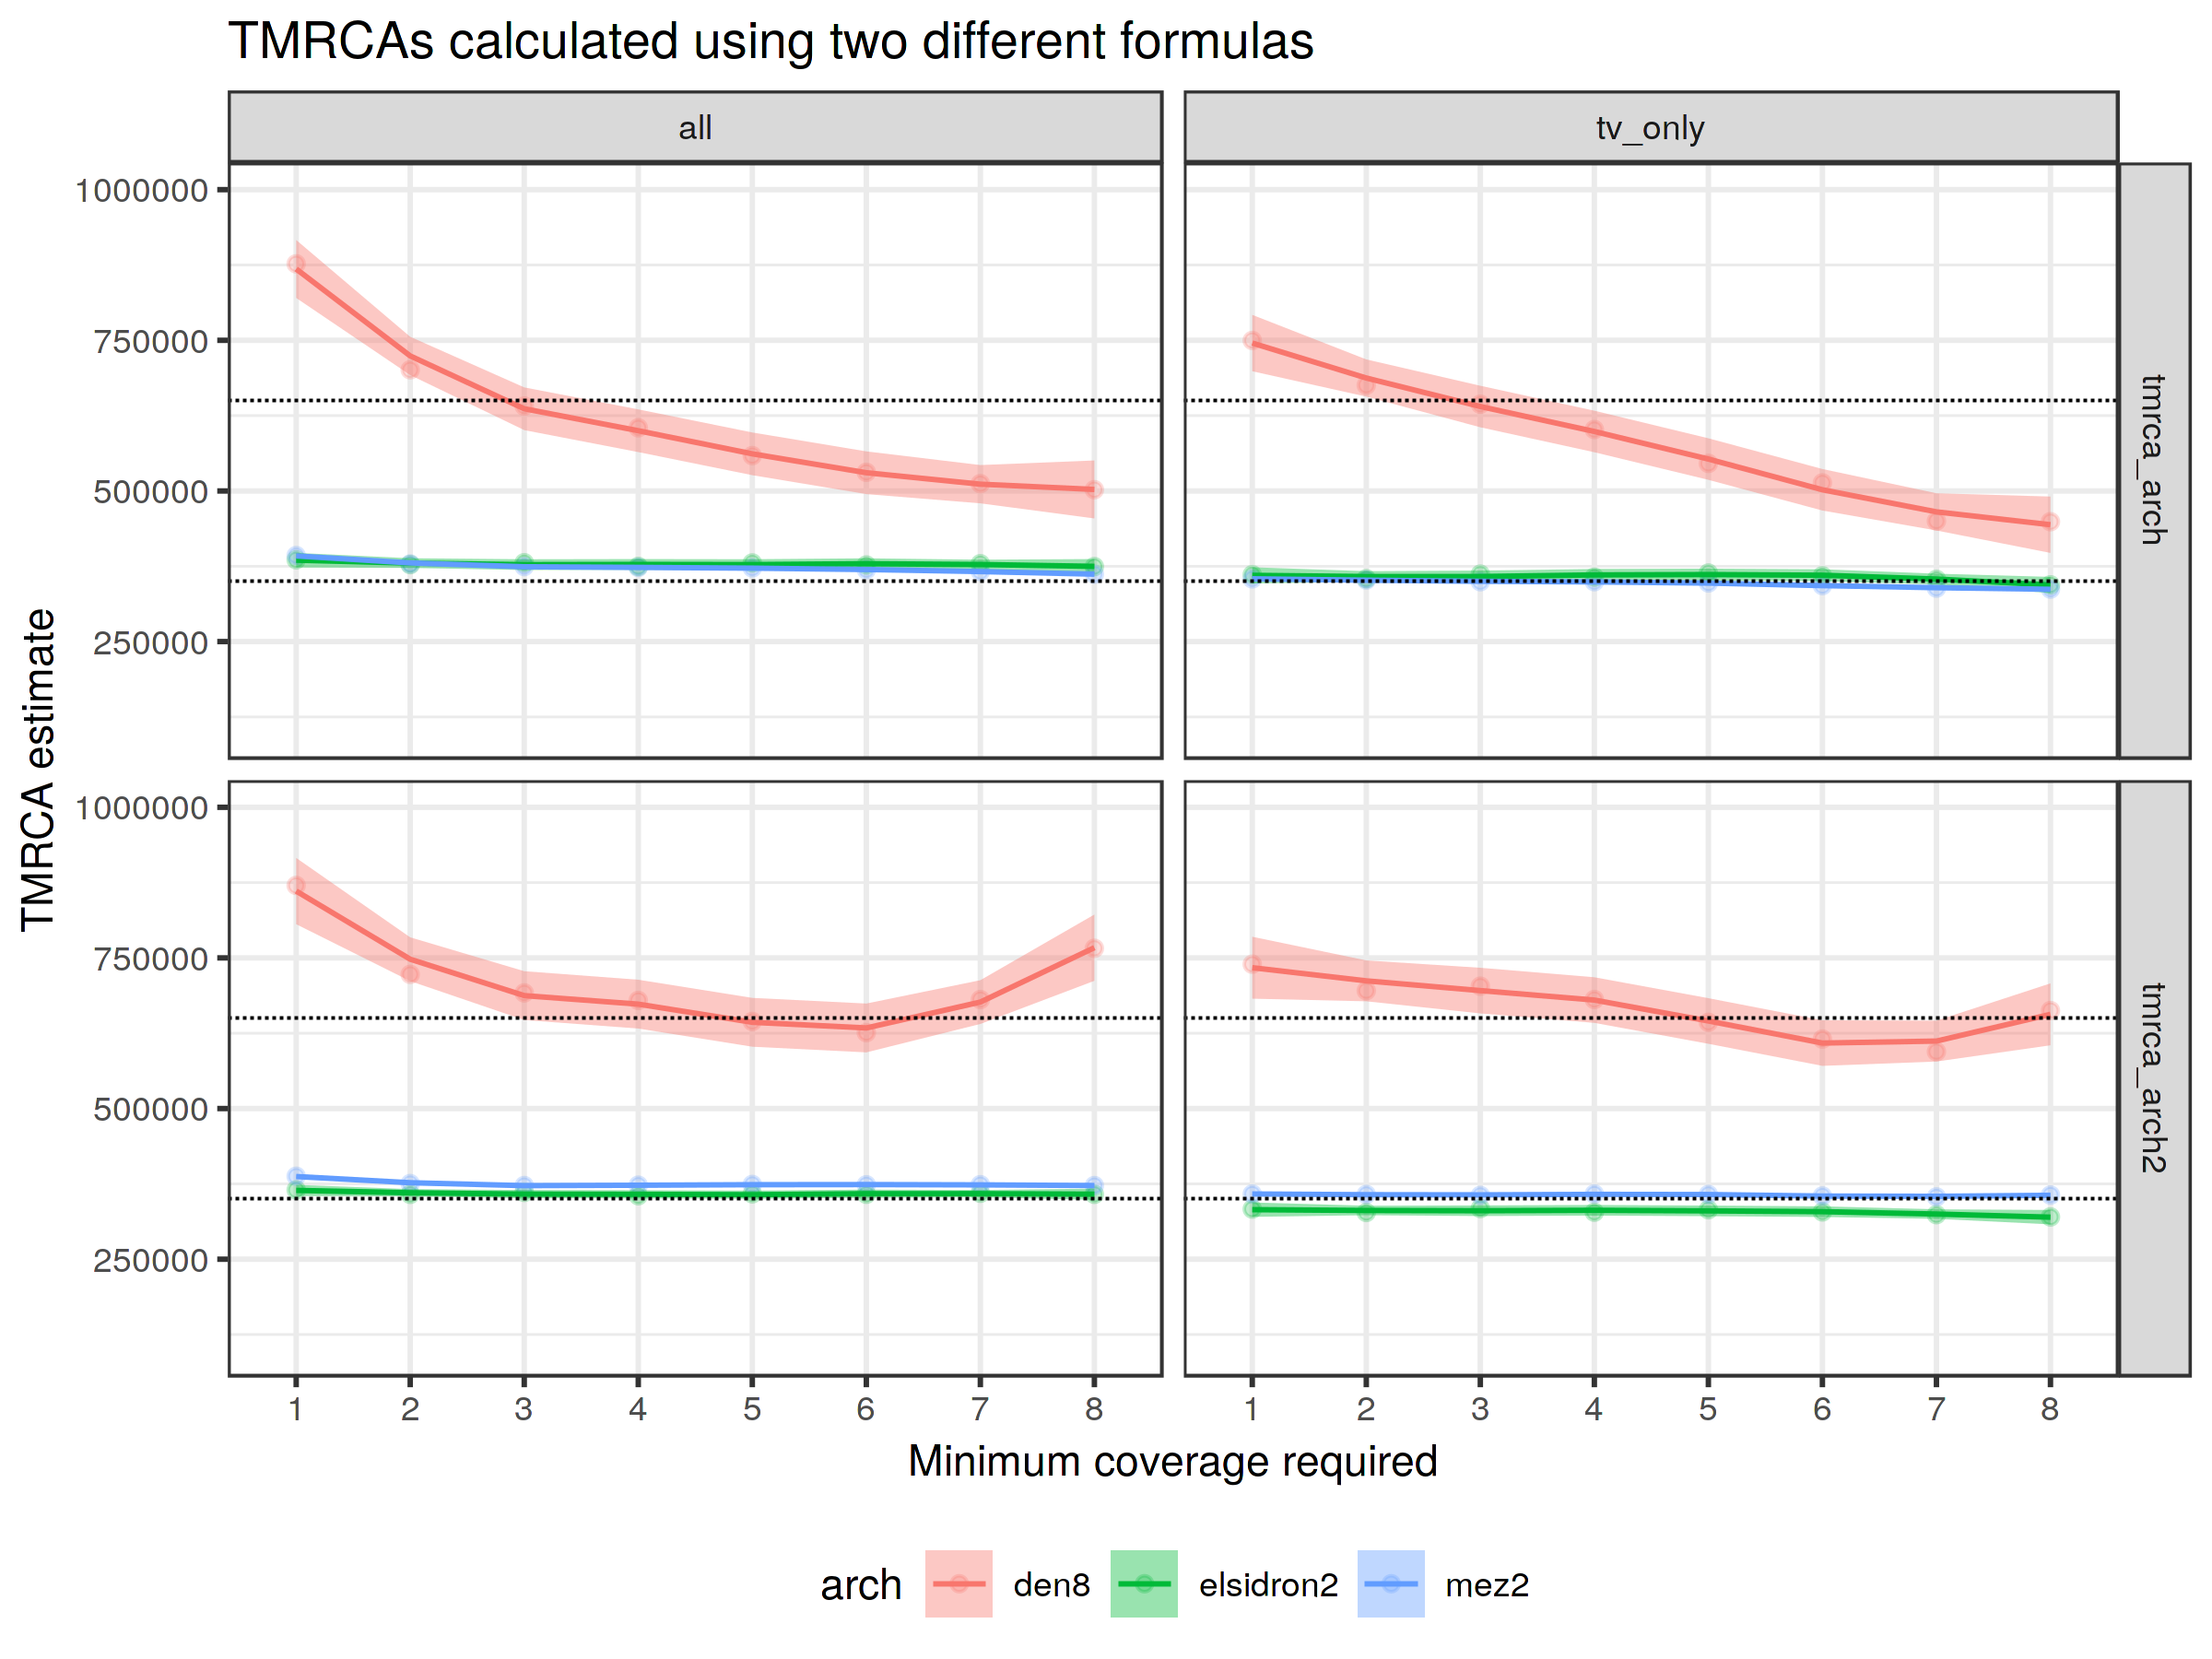

In [12]:
set_dim(8, 6)

tmrca_df %>%
filter(afr == "a00", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2") %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, sites, dp) %>%
group_by(arch, sites, dp) %>% summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    coord_cartesian(y = c(100000, 1000000)) +
    facet_grid(tmrca ~ sites) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

# Why do `d` and `e` counts differ so much depending on coverage?

# How does that depend on a chosen African?

In [13]:
set_dim(6, 3)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00") %>%
filter(capture == "full" & arch %in% c("den8"), sites == "all") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>% select(-starts_with("tmrca"), -mut_rate) %>%
group_by(arch, afr, dp) %>%
summarise_if(is.numeric, mean) %>%
arrange(dp) %>%
mutate(d_a = d / a, e_a = e / a, d_e = d / e)

arch,afr,dp,alpha,a,b,c,d,e,f,total,n_muts,d_a,e_a,d_e
den8,a00,1,3.585851,2193.38462,55.2307692,23.769231,857.53846,839.00000,20371.92308,4916308.0,24340.8462,0.3909658,0.3825139,1.0220959
den8,a00,2,2.866927,1274.53846,41.9230769,18.923077,652.15385,713.38462,2822.00000,4127493.1,5522.9231,0.5116784,0.5597200,0.9141686
den8,a00,3,2.620671,826.76923,32.2307692,13.461538,452.23077,568.23077,1073.00000,3226978.8,2965.9231,0.5469855,0.6872907,0.7958576
den8,a00,4,2.473522,510.92308,21.6153846,10.384615,287.61538,406.07692,607.61538,2342622.6,1844.2308,0.5629329,0.7947907,0.7082781
den8,a00,5,2.285260,282.92308,7.8461538,8.692308,173.15385,267.30769,347.69231,1572713.2,1087.6154,0.6120174,0.9448070,0.6477698
den8,a00,6,2.171504,154.15385,3.8461538,2.307692,99.15385,164.23077,198.07692,974623.4,621.7692,0.6432136,1.0653693,0.6037471
den8,a00,7,2.094767,78.07692,0.8461538,1.615385,44.23077,98.61538,95.76923,549088.7,319.1538,0.5665025,1.2630542,0.4485179
den8,a00,8,2.053920,37.23077,0.0000000,1.230769,18.07692,52.76923,45.69231,271434.3,155.0000,0.4855372,1.4173554,0.3425656


^^^ note that the `a` length is getting A LOT shorter as we increase the coverage cutoff

d/e ~1 for DP >= 1, as it should be, because there's no reason for them to be different, really

### Does the following mean that the `a` branch is getting increasingly shorter than `e` the higher the required coverage cutoff is?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


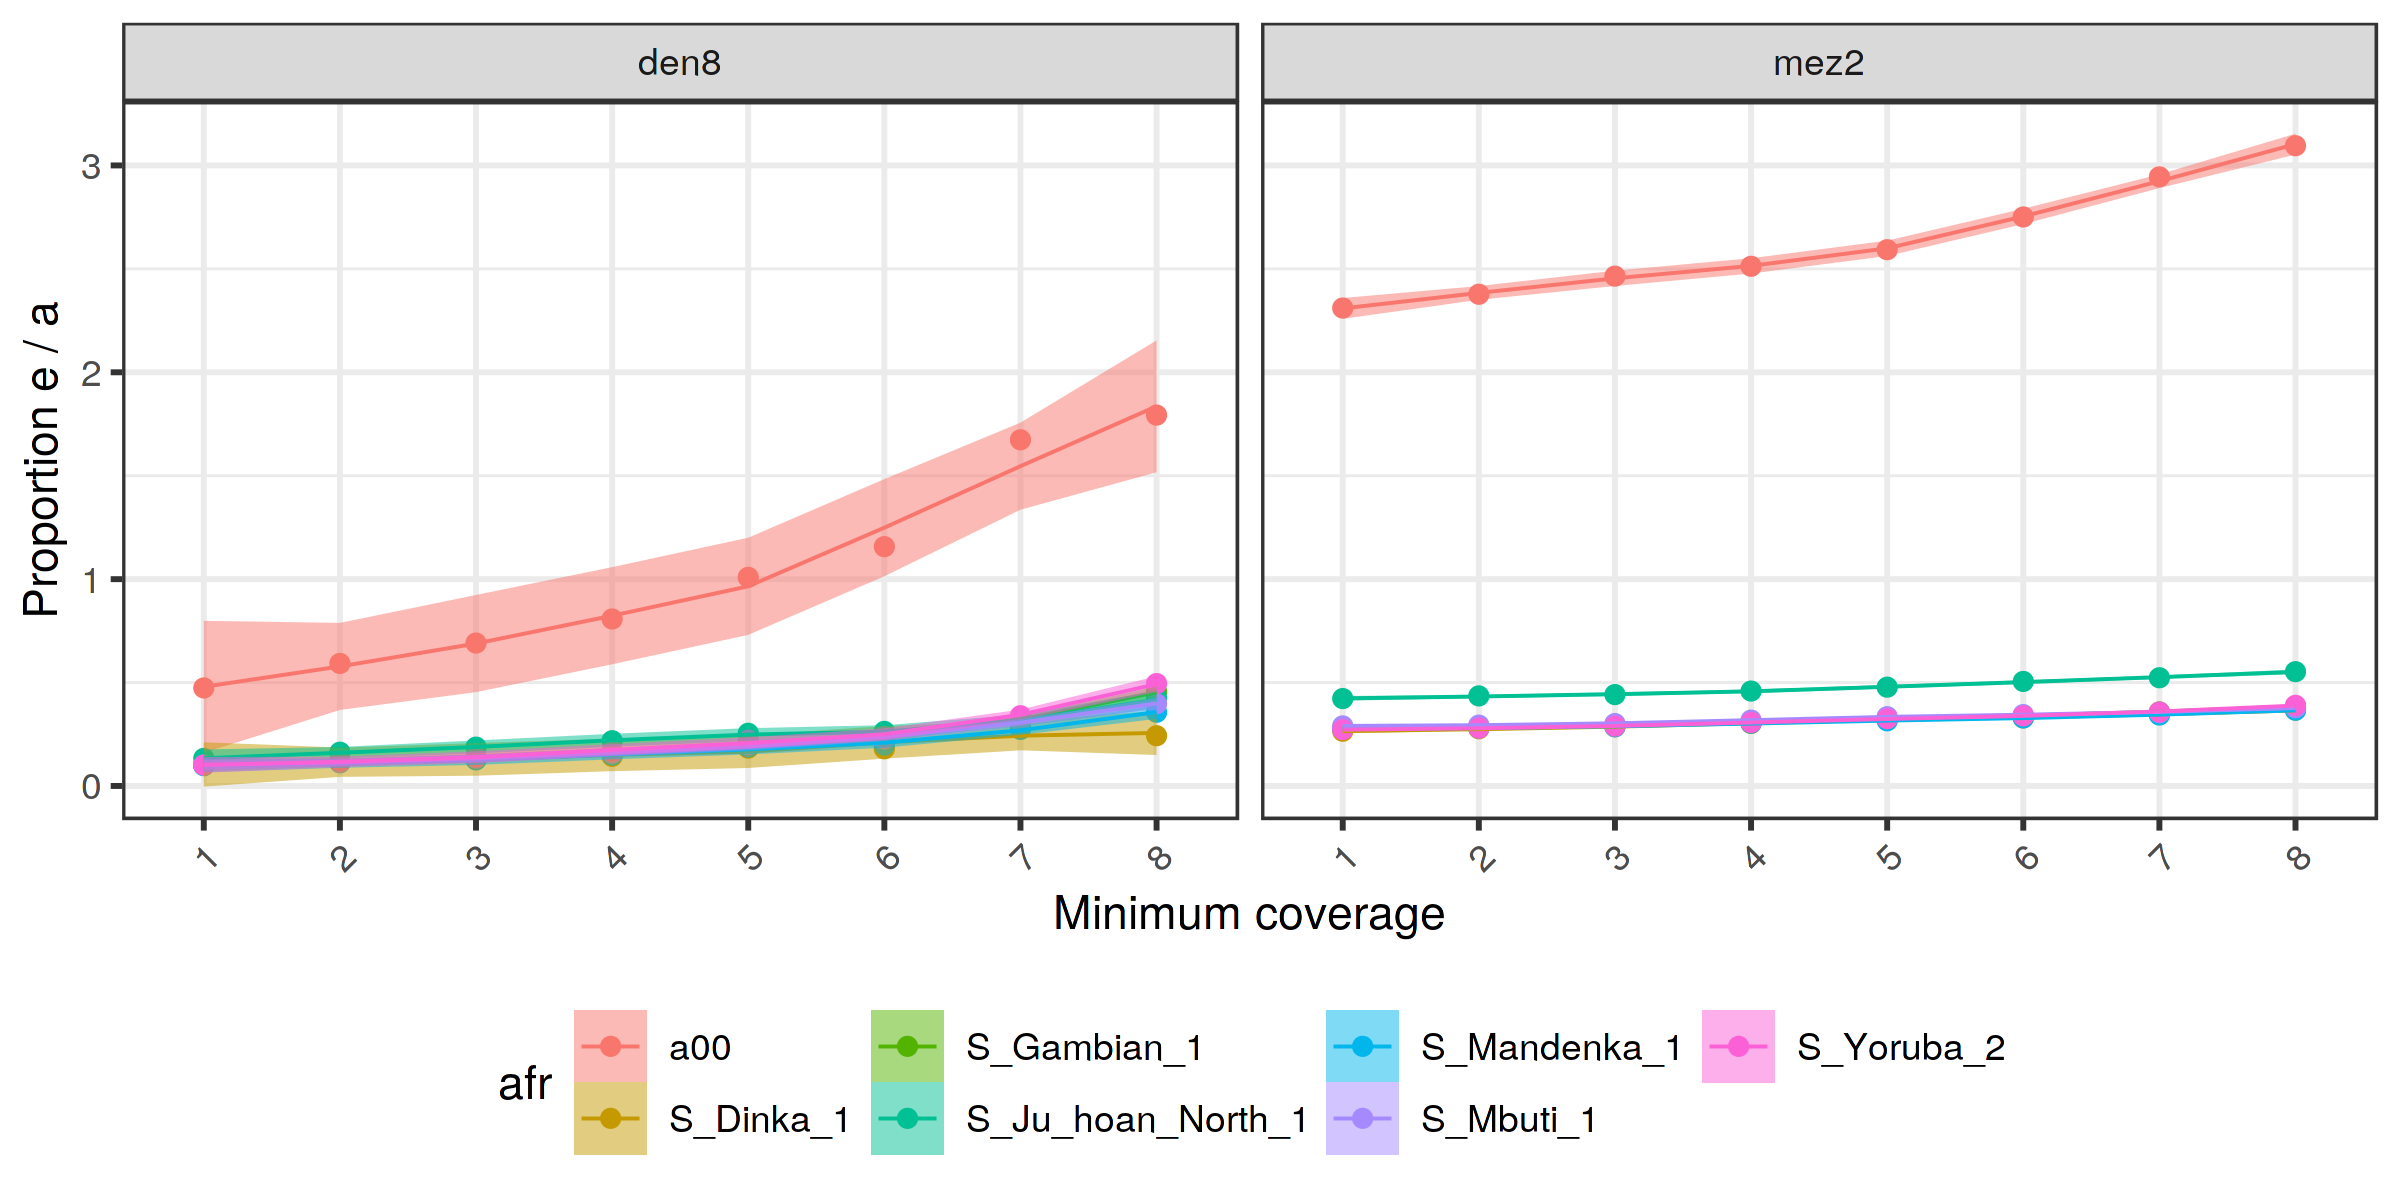

In [14]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(dp < 9, sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### ... but not the `d` branch... ?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


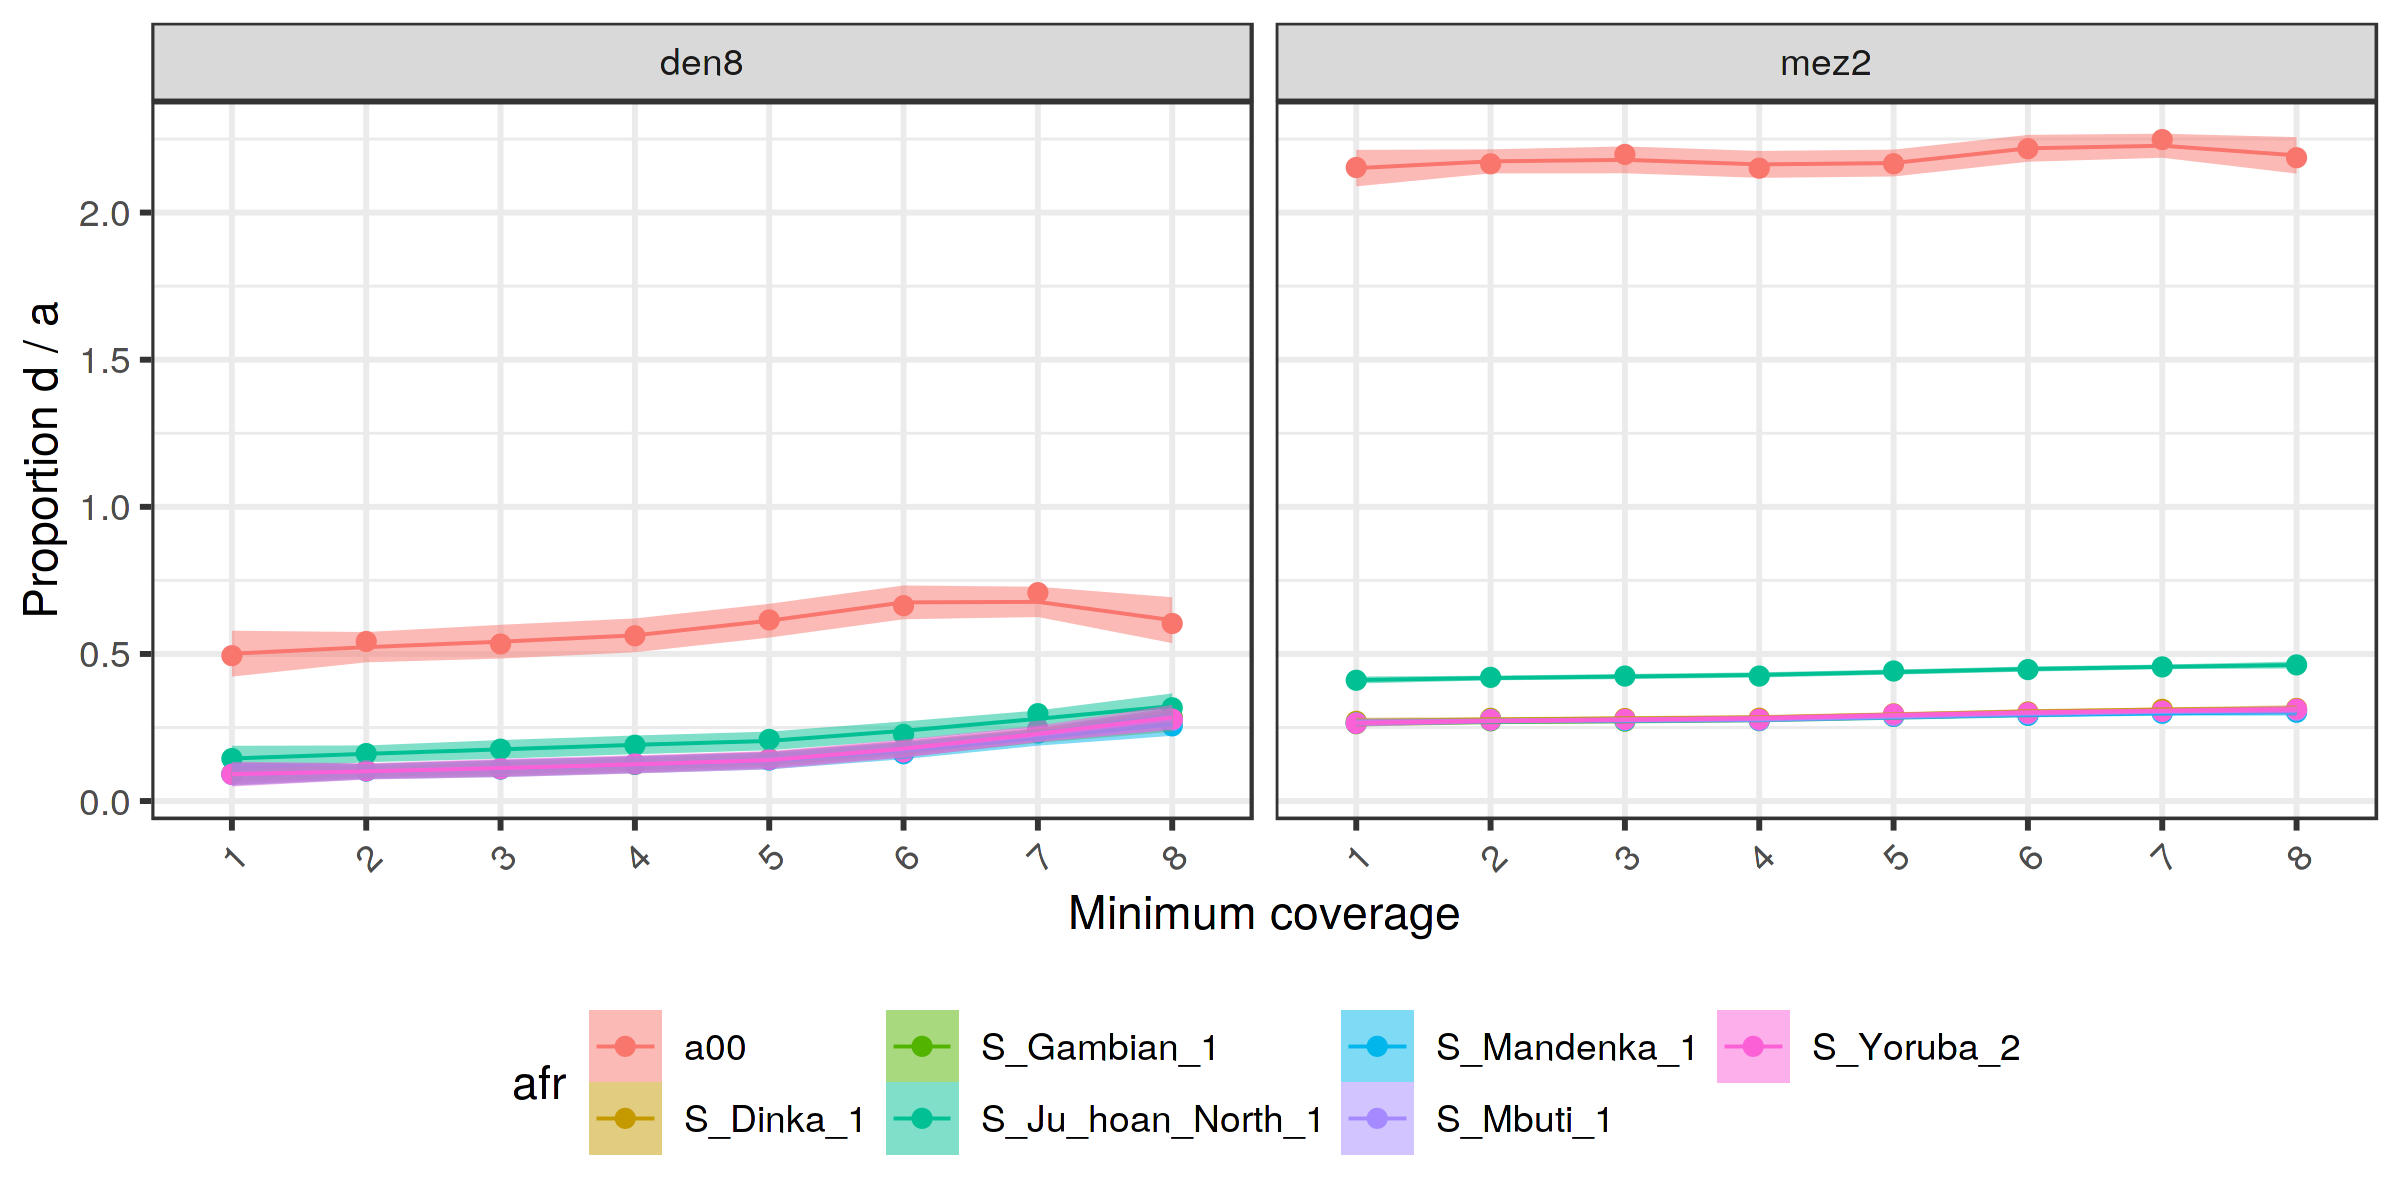

In [15]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(dp < 9, sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### What about `d` vs `e`? This proportion should be ~1.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


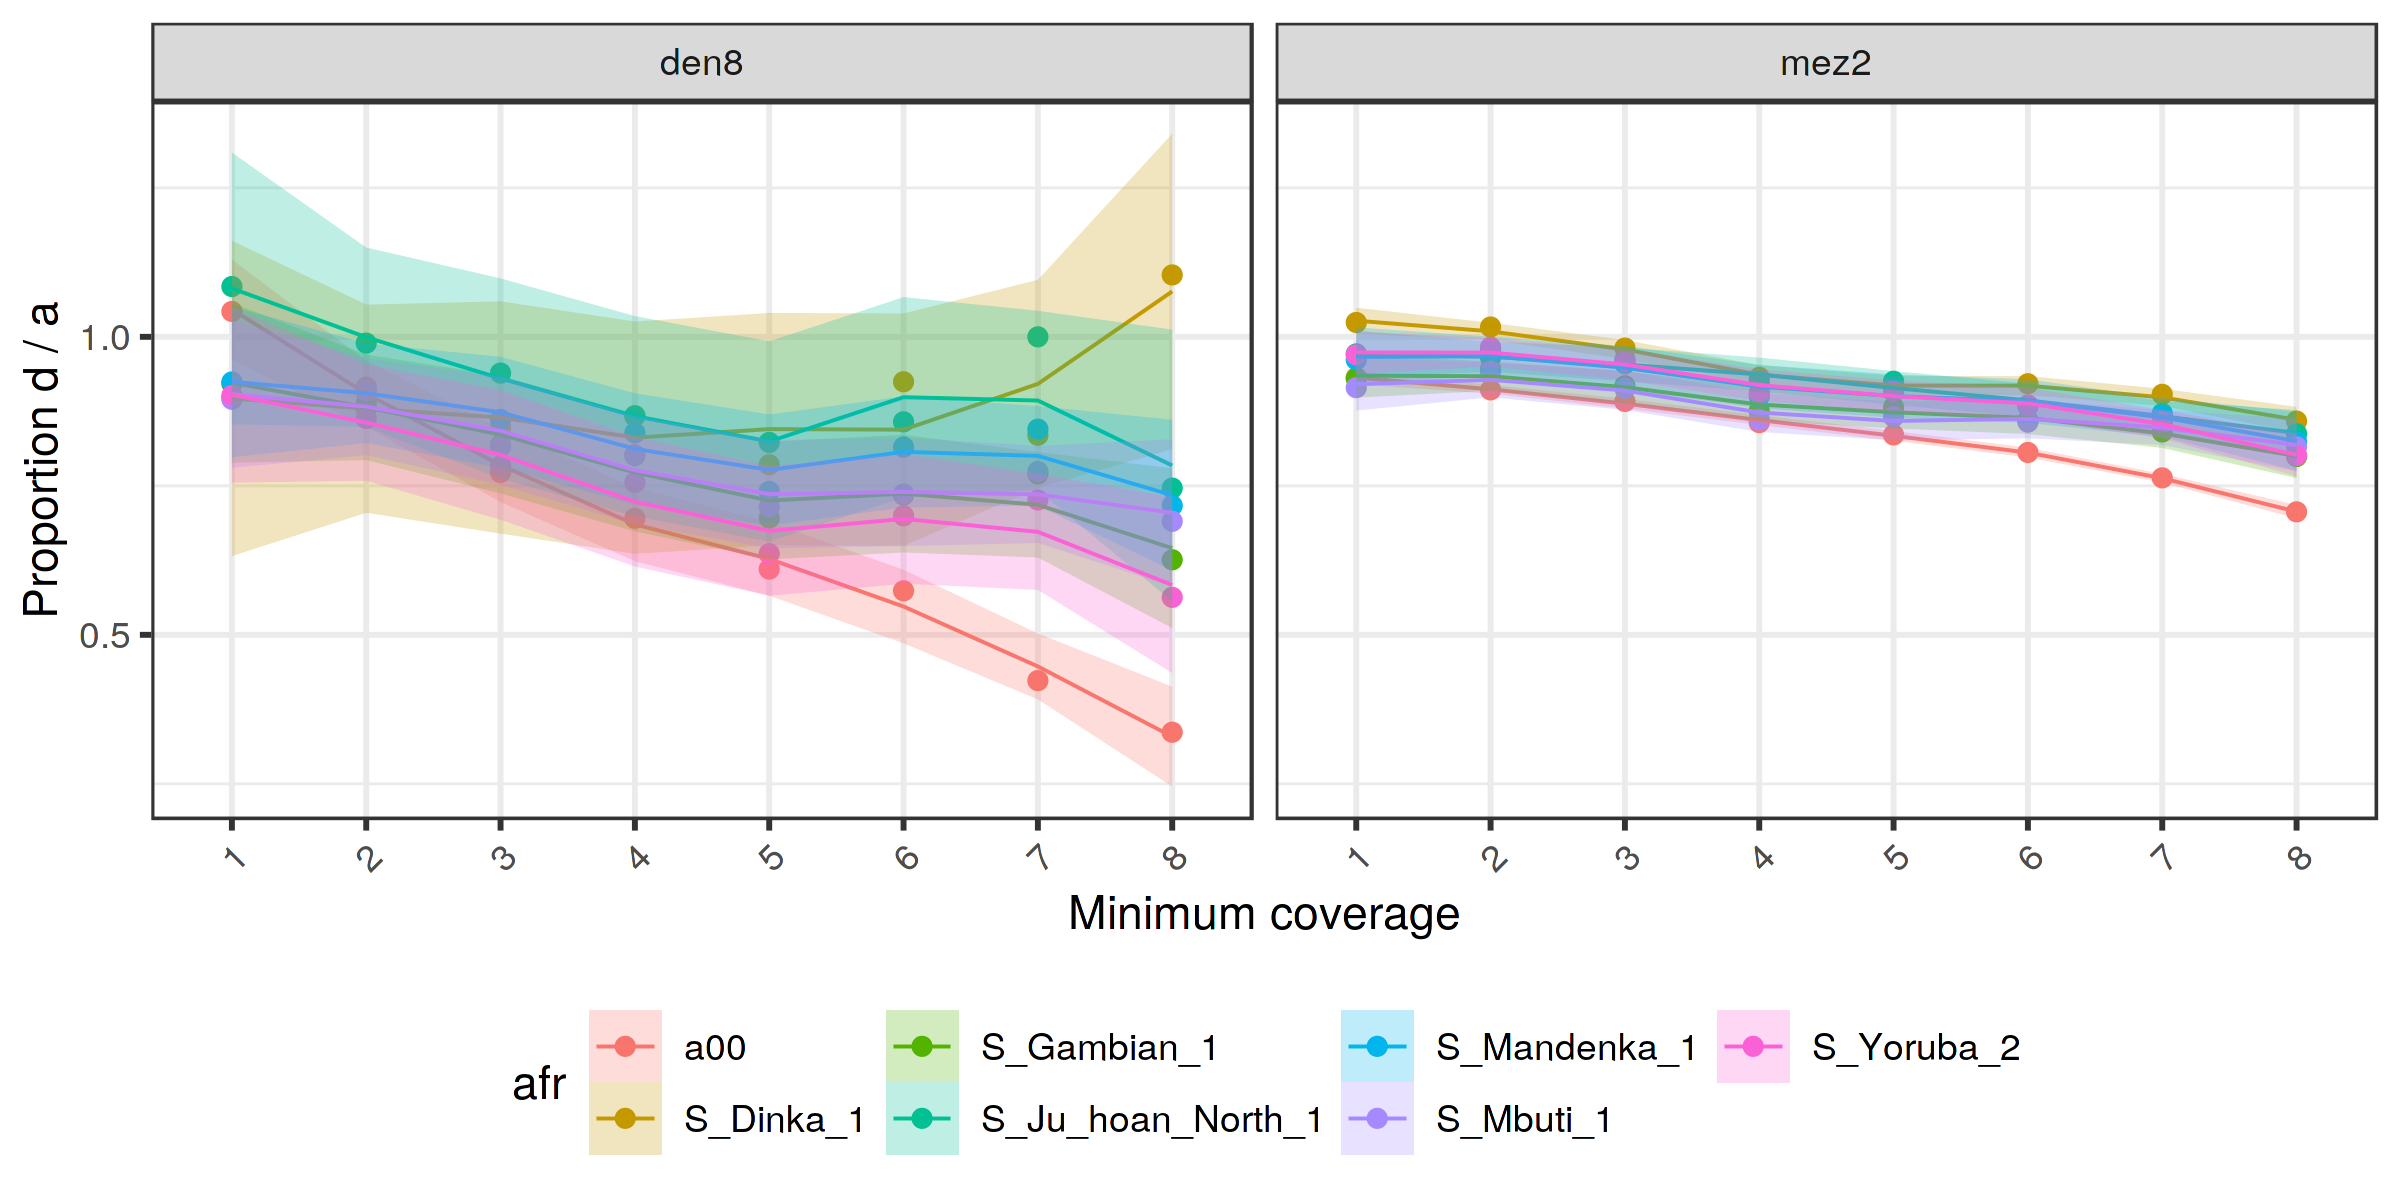

In [16]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(dp < 9, sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / e) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/4) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### A00 - both `a` and `d` relatively stable across coverage, but `e` is increasing

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


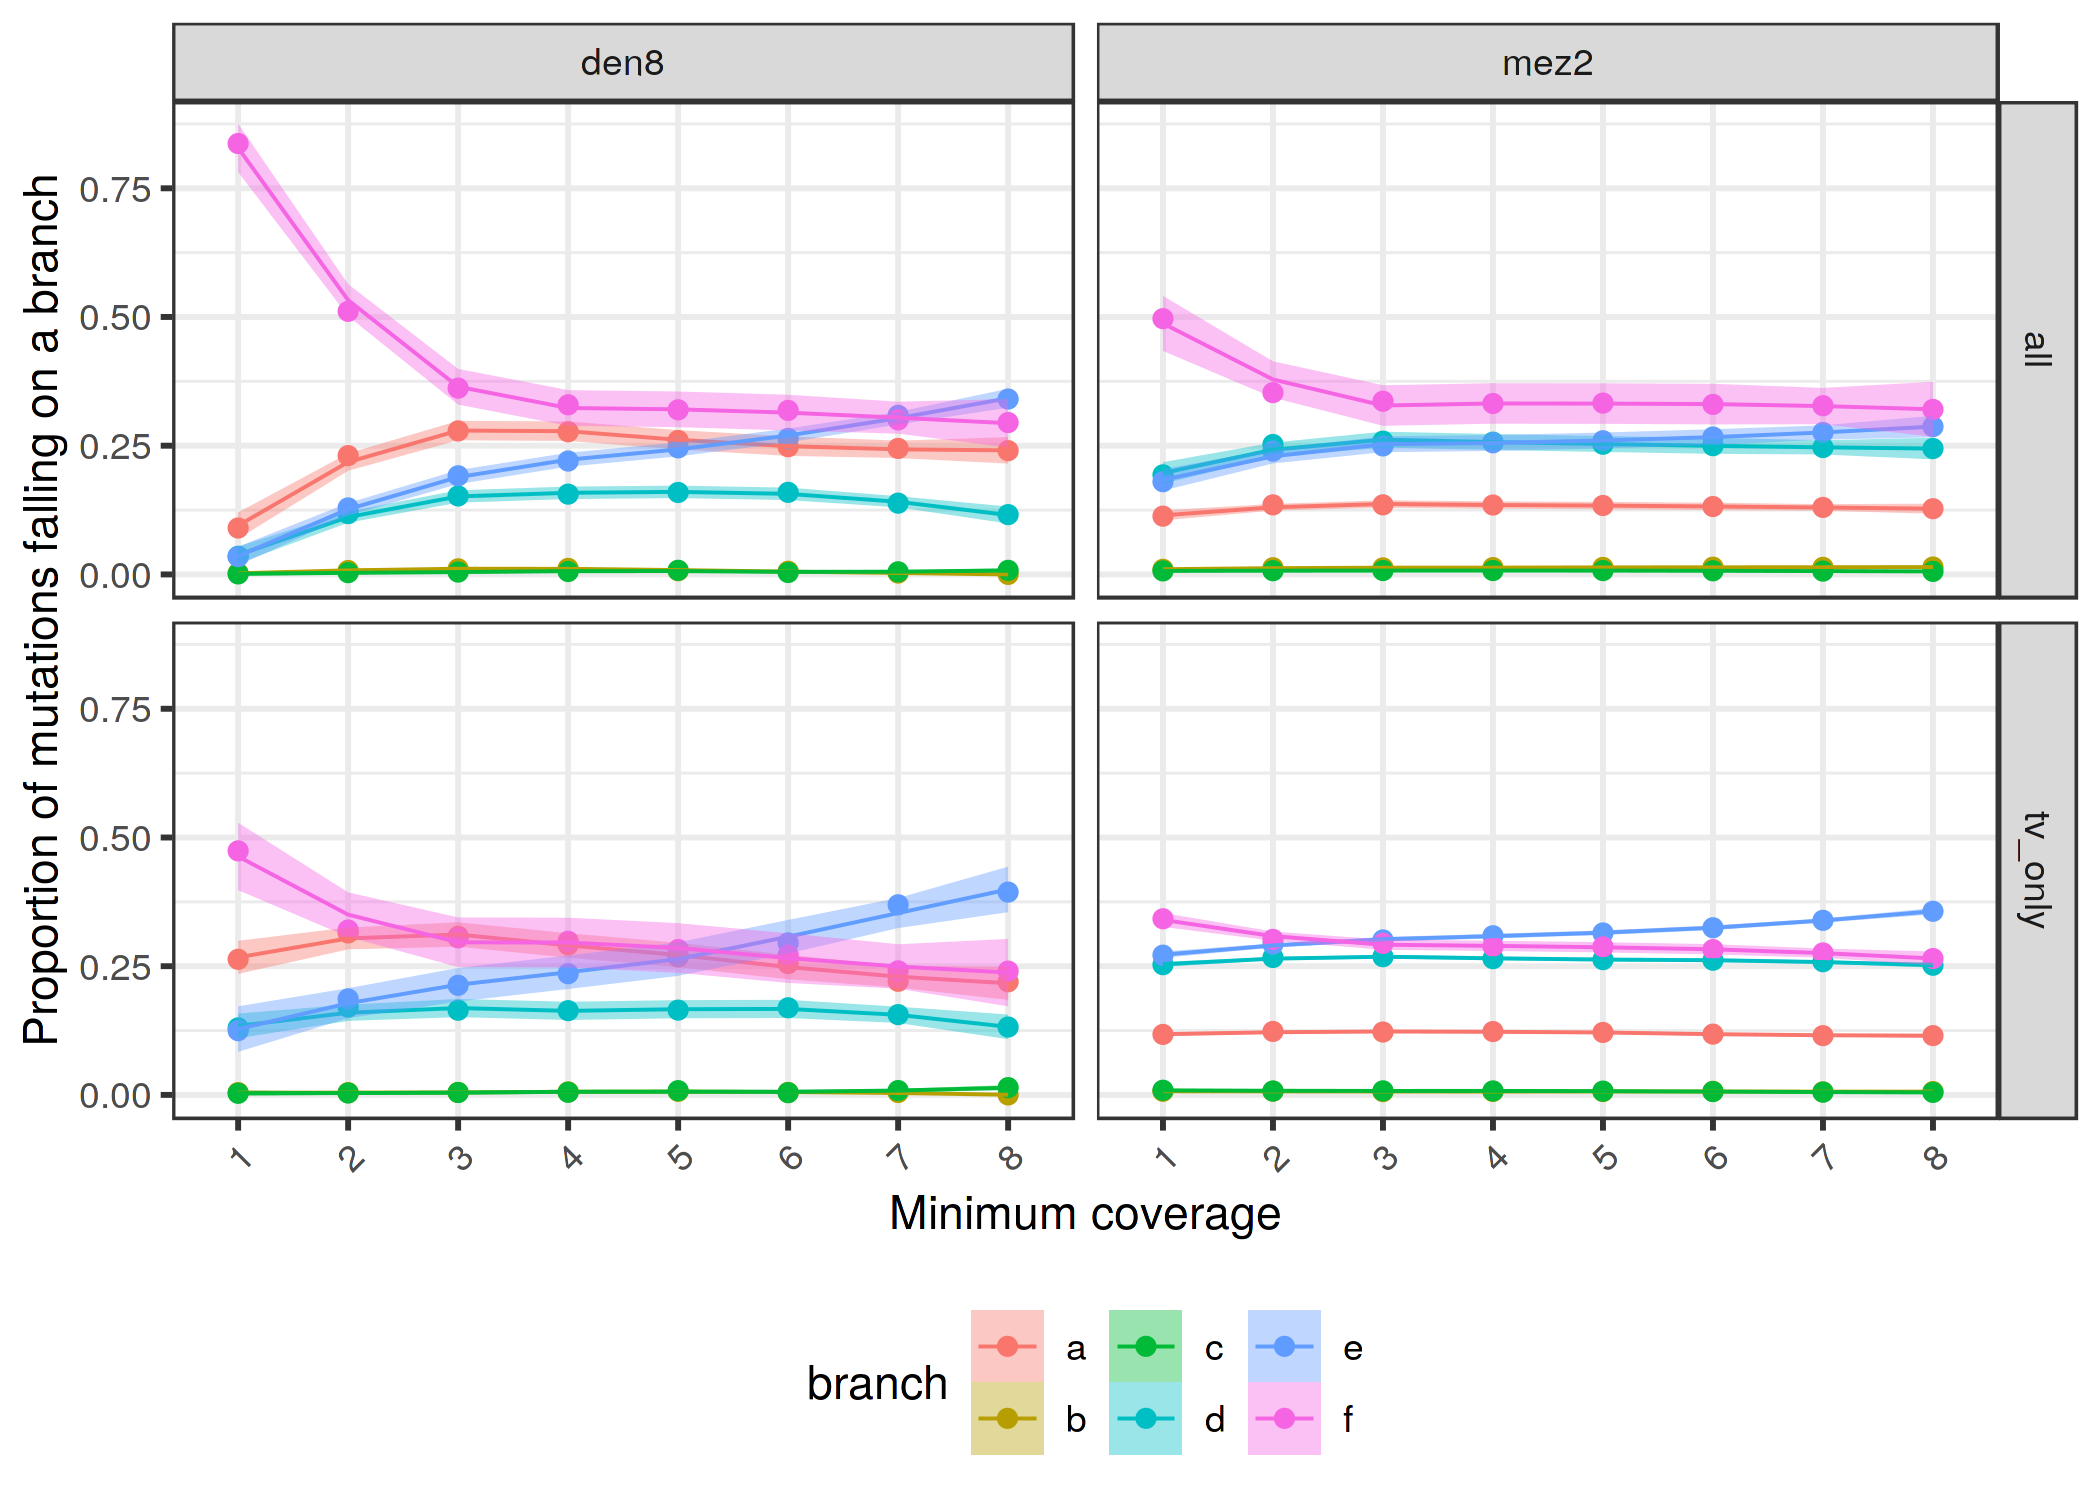

In [17]:
set_dim(7, 5)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
mutate(prop = count / n_muts) %>%
group_by(arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean) %>%
ggplot(aes(as.factor(dp), prop, color = branch, fill = branch, group = branch)) +
    geom_point() +
    geom_smooth(size = 1/3) +
    facet_grid(sites ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion of mutations falling on a branch") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

^^^ `a` and `f` appear to level after `dp >= 3` which seems OK???

but `e` is increasing steadily - this is super weird and could be driving `a / (a + d + e)` higher at higher cutoffs?
* is the increased proportion of `e` branch the reference bias signal?


### other Africans -  `a` relatively stable across coverage, but both `d` and `e` are increasing

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


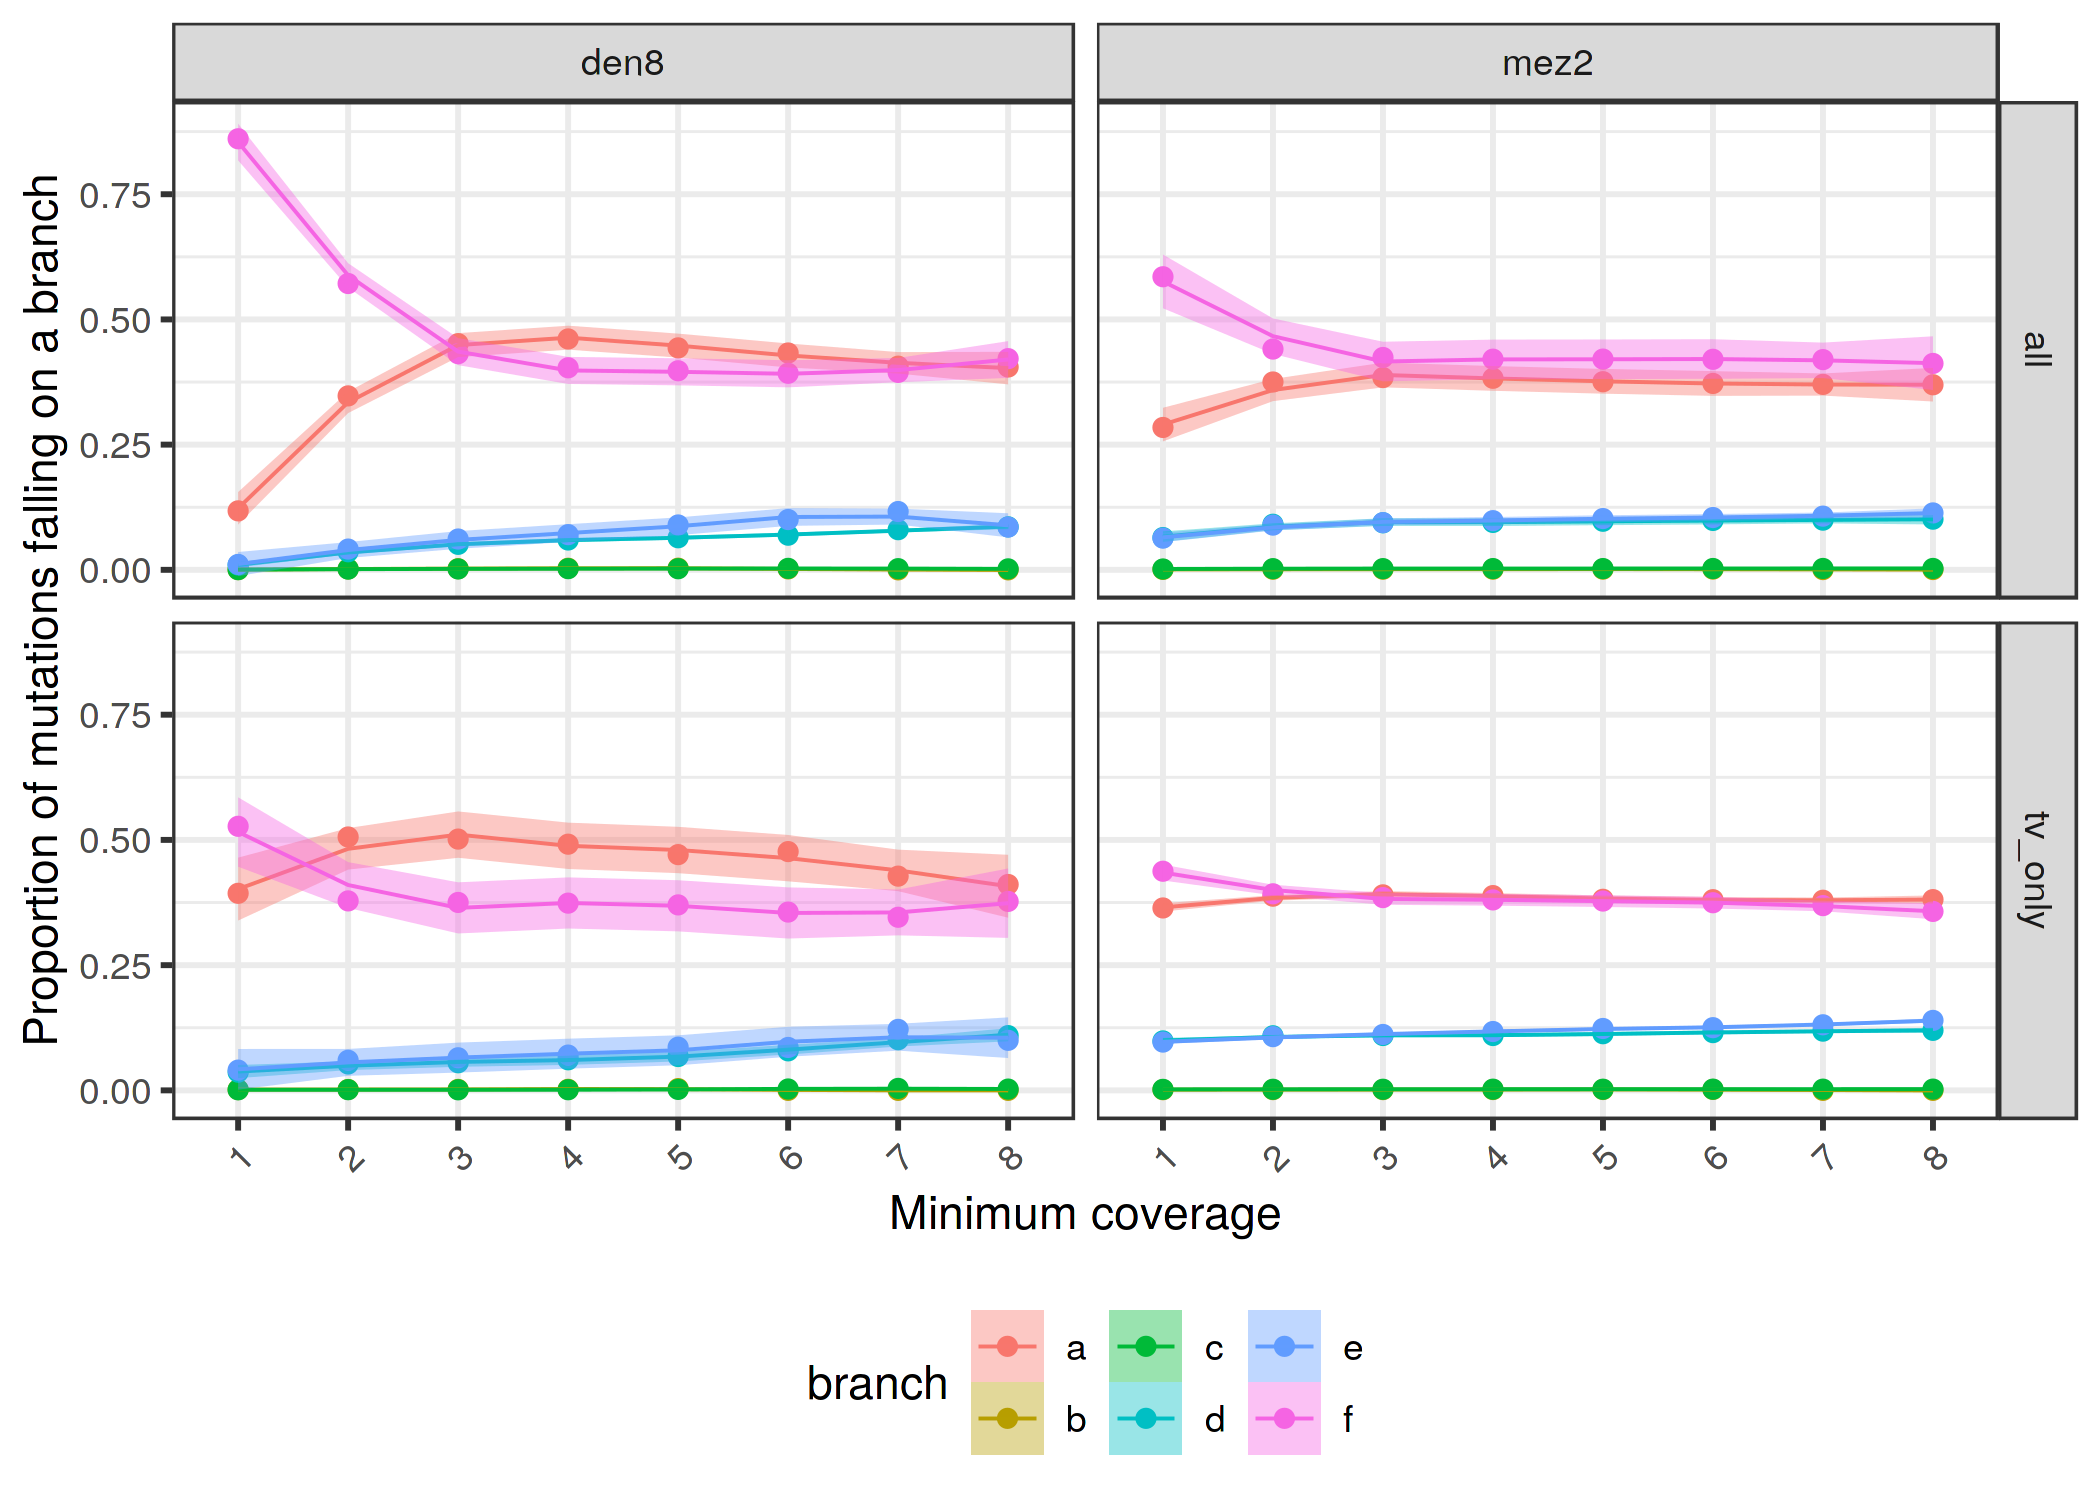

In [16]:
set_dim(7, 5)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "S_Dinka_1", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
mutate(prop = count / n_muts) %>%
group_by(arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean) %>%
ggplot(aes(as.factor(dp), prop, color = branch, fill = branch, group = branch)) +
    geom_point() +
    geom_smooth(size = 1/3) +
    facet_grid(sites ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion of mutations falling on a branch") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


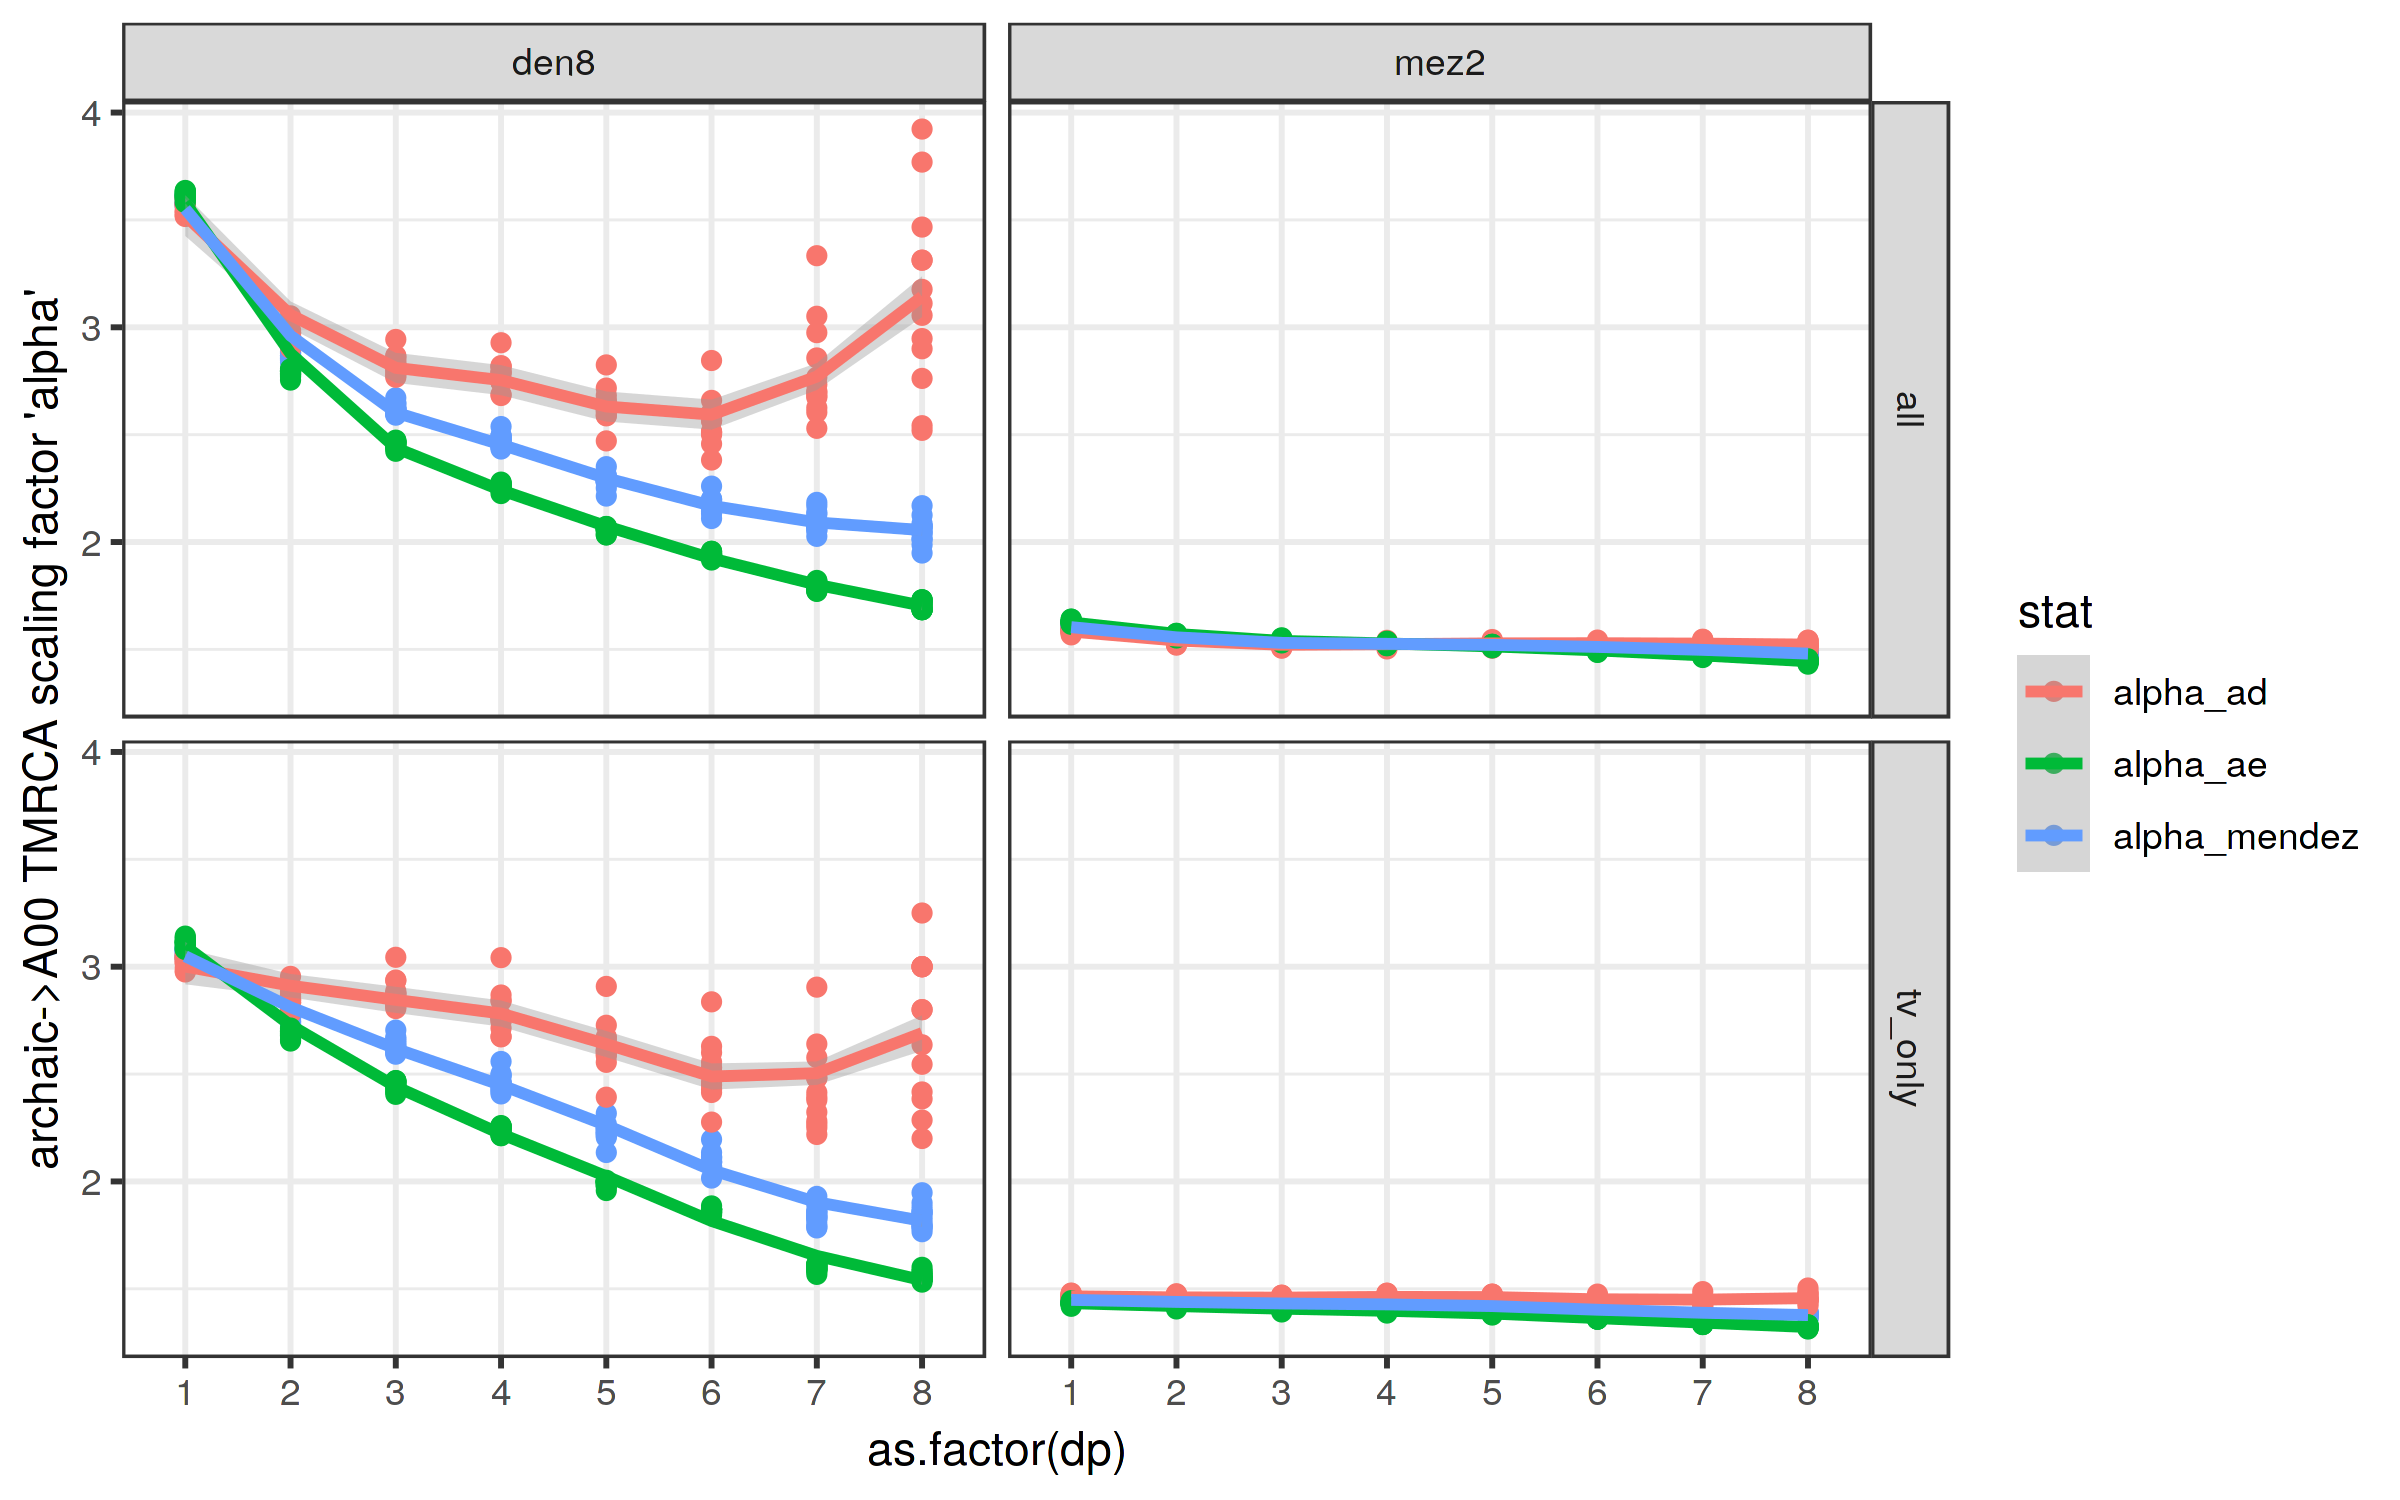

In [18]:
set_dim(8, 5)

tmrca_df %>%
filter(dp < 9, capture == "full", afr == "a00", arch %in% c("mez2", "den8")) %>% unnest(counts_arch) %>%
select(arch, dp, tmrca_arch, alpha_mendez = alpha, sites, tmrca_f, a, b, c, d, e, f) %>%
mutate(
    alpha_ad = (a + d) / d,
    alpha_ae = (a + e) / e
) %>%
select(arch, dp, sites, starts_with("alpha")) %>%
gather(stat, value, -arch, -dp, -sites) %>%
ggplot(aes(as.factor(dp), value, color = stat)) +
    geom_point() +
    geom_smooth(aes(group = stat)) +
    theme_bw() +
    facet_grid(sites ~ arch) +
    ylab("archaic->A00 TMRCA scaling factor 'alpha'")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


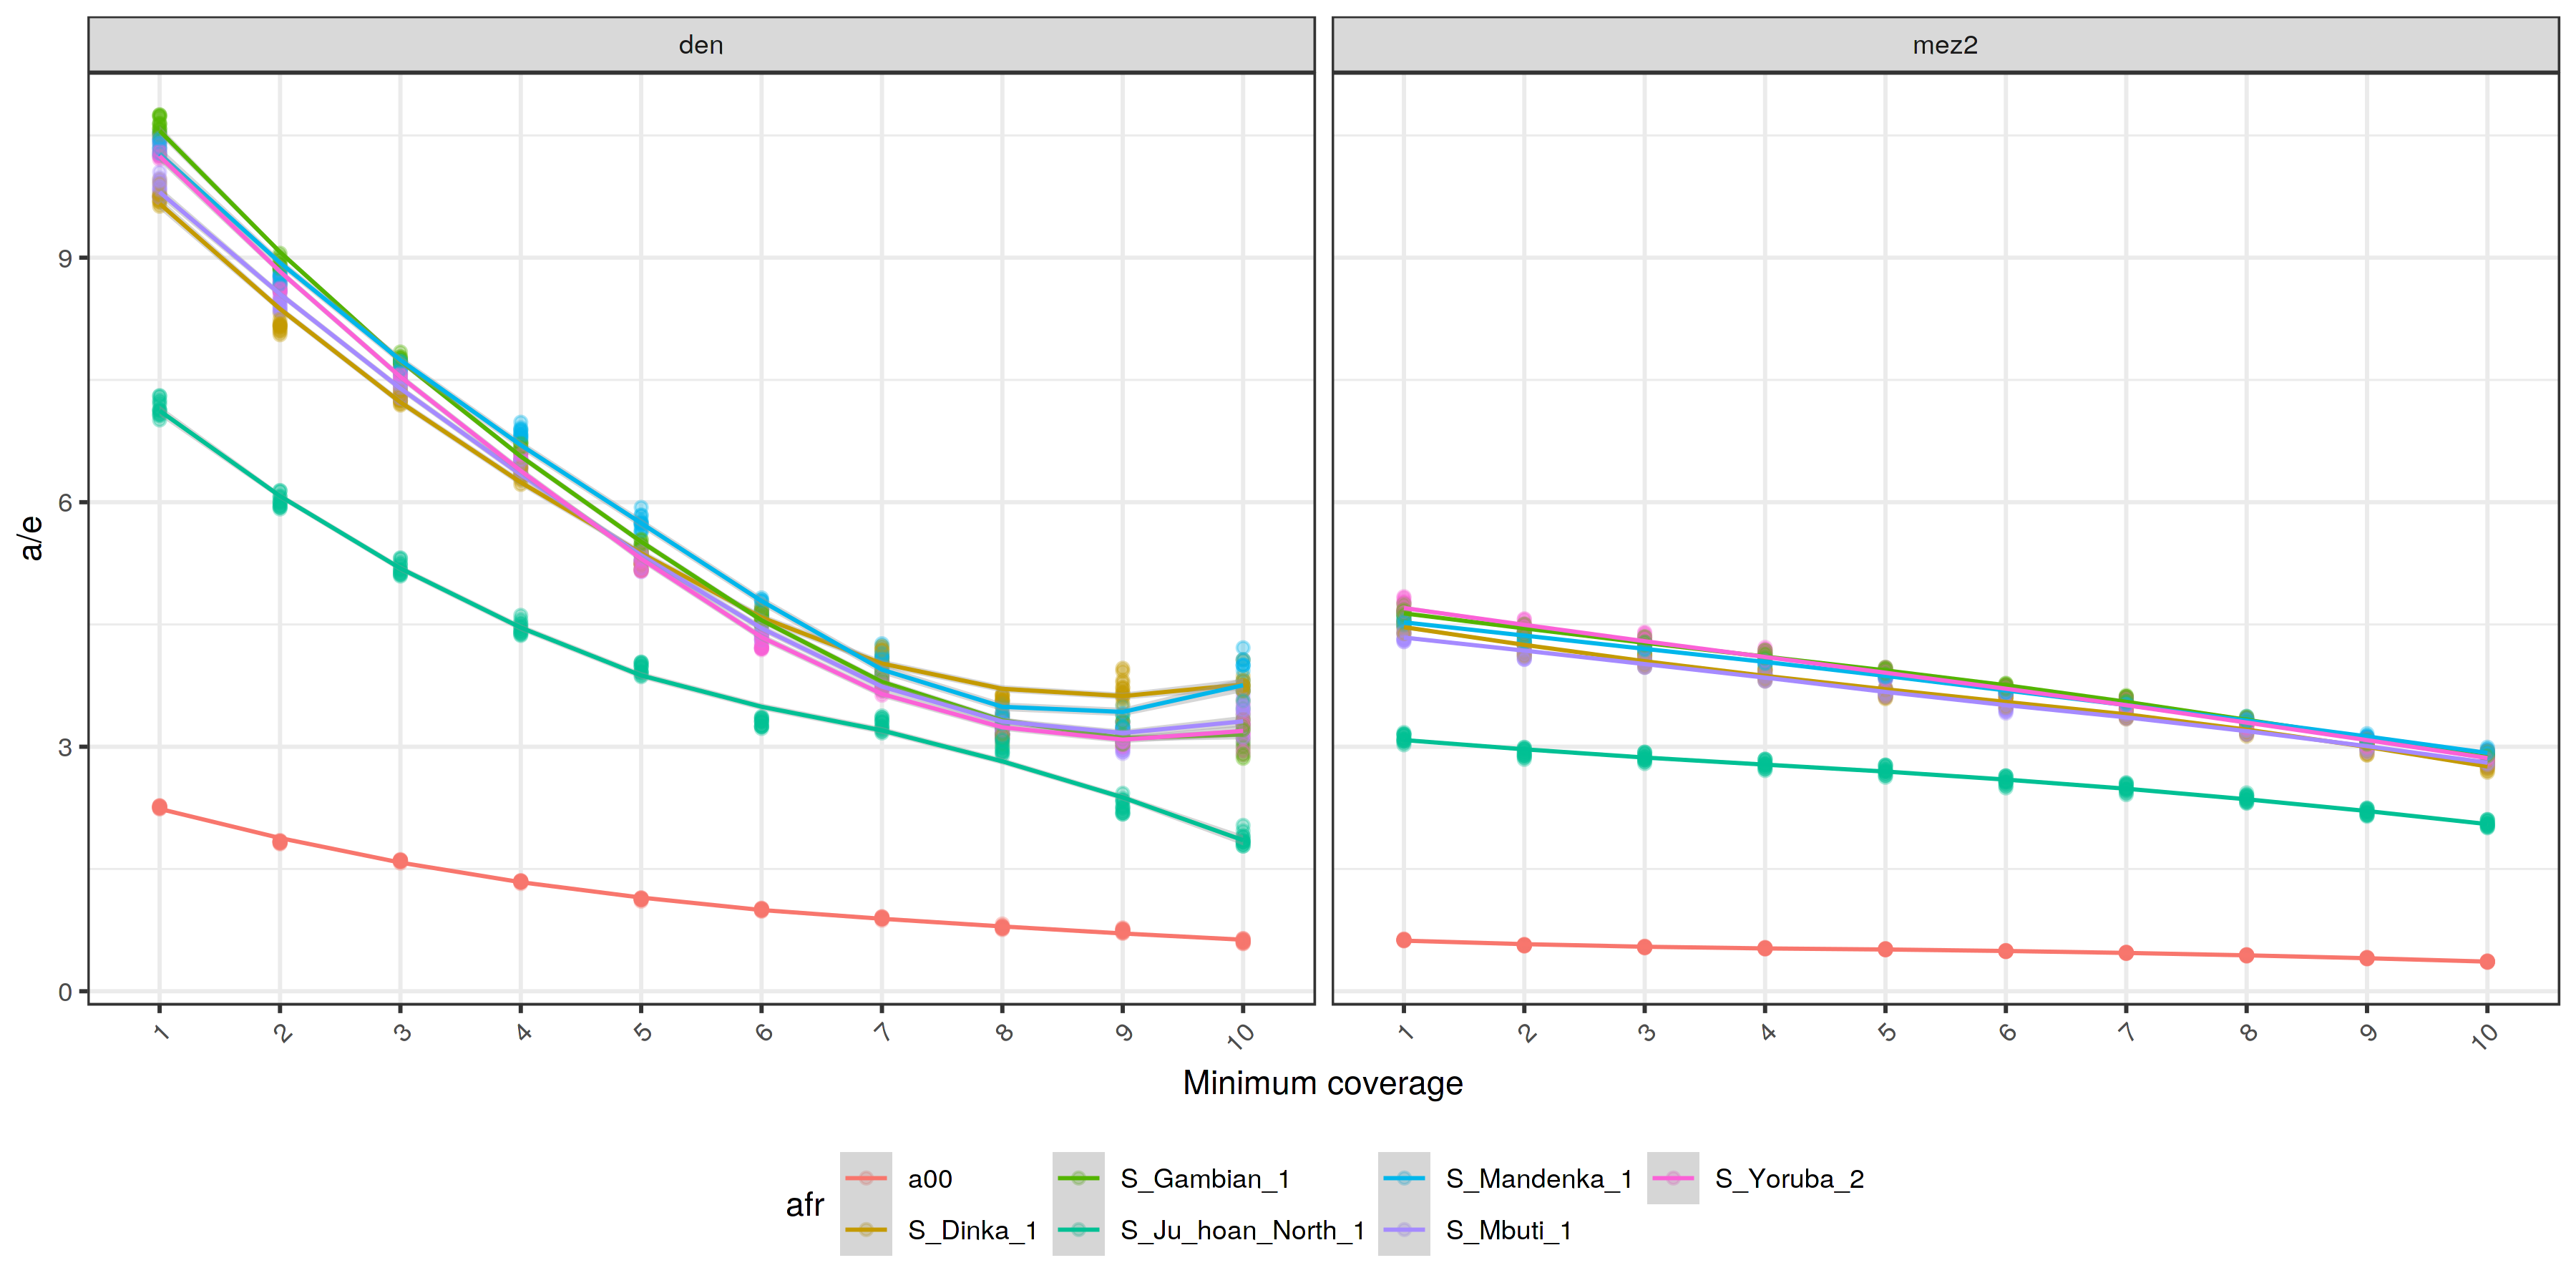

In [344]:
set_dim(12, 6)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(capture == "full", sites == "all", !arch %in% c("den8", "den4", "neand", "spy1")) %>% 
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts) %>%
ggplot(aes(as.factor(dp), a / e, color = afr)) +
    geom_point(alpha = 1/3) +
    geom_smooth(aes(group = afr), size = 0.5) +
    facet_wrap(arch ~ ., ncol = 6) +
    theme_bw() + xlab("Minimum coverage") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


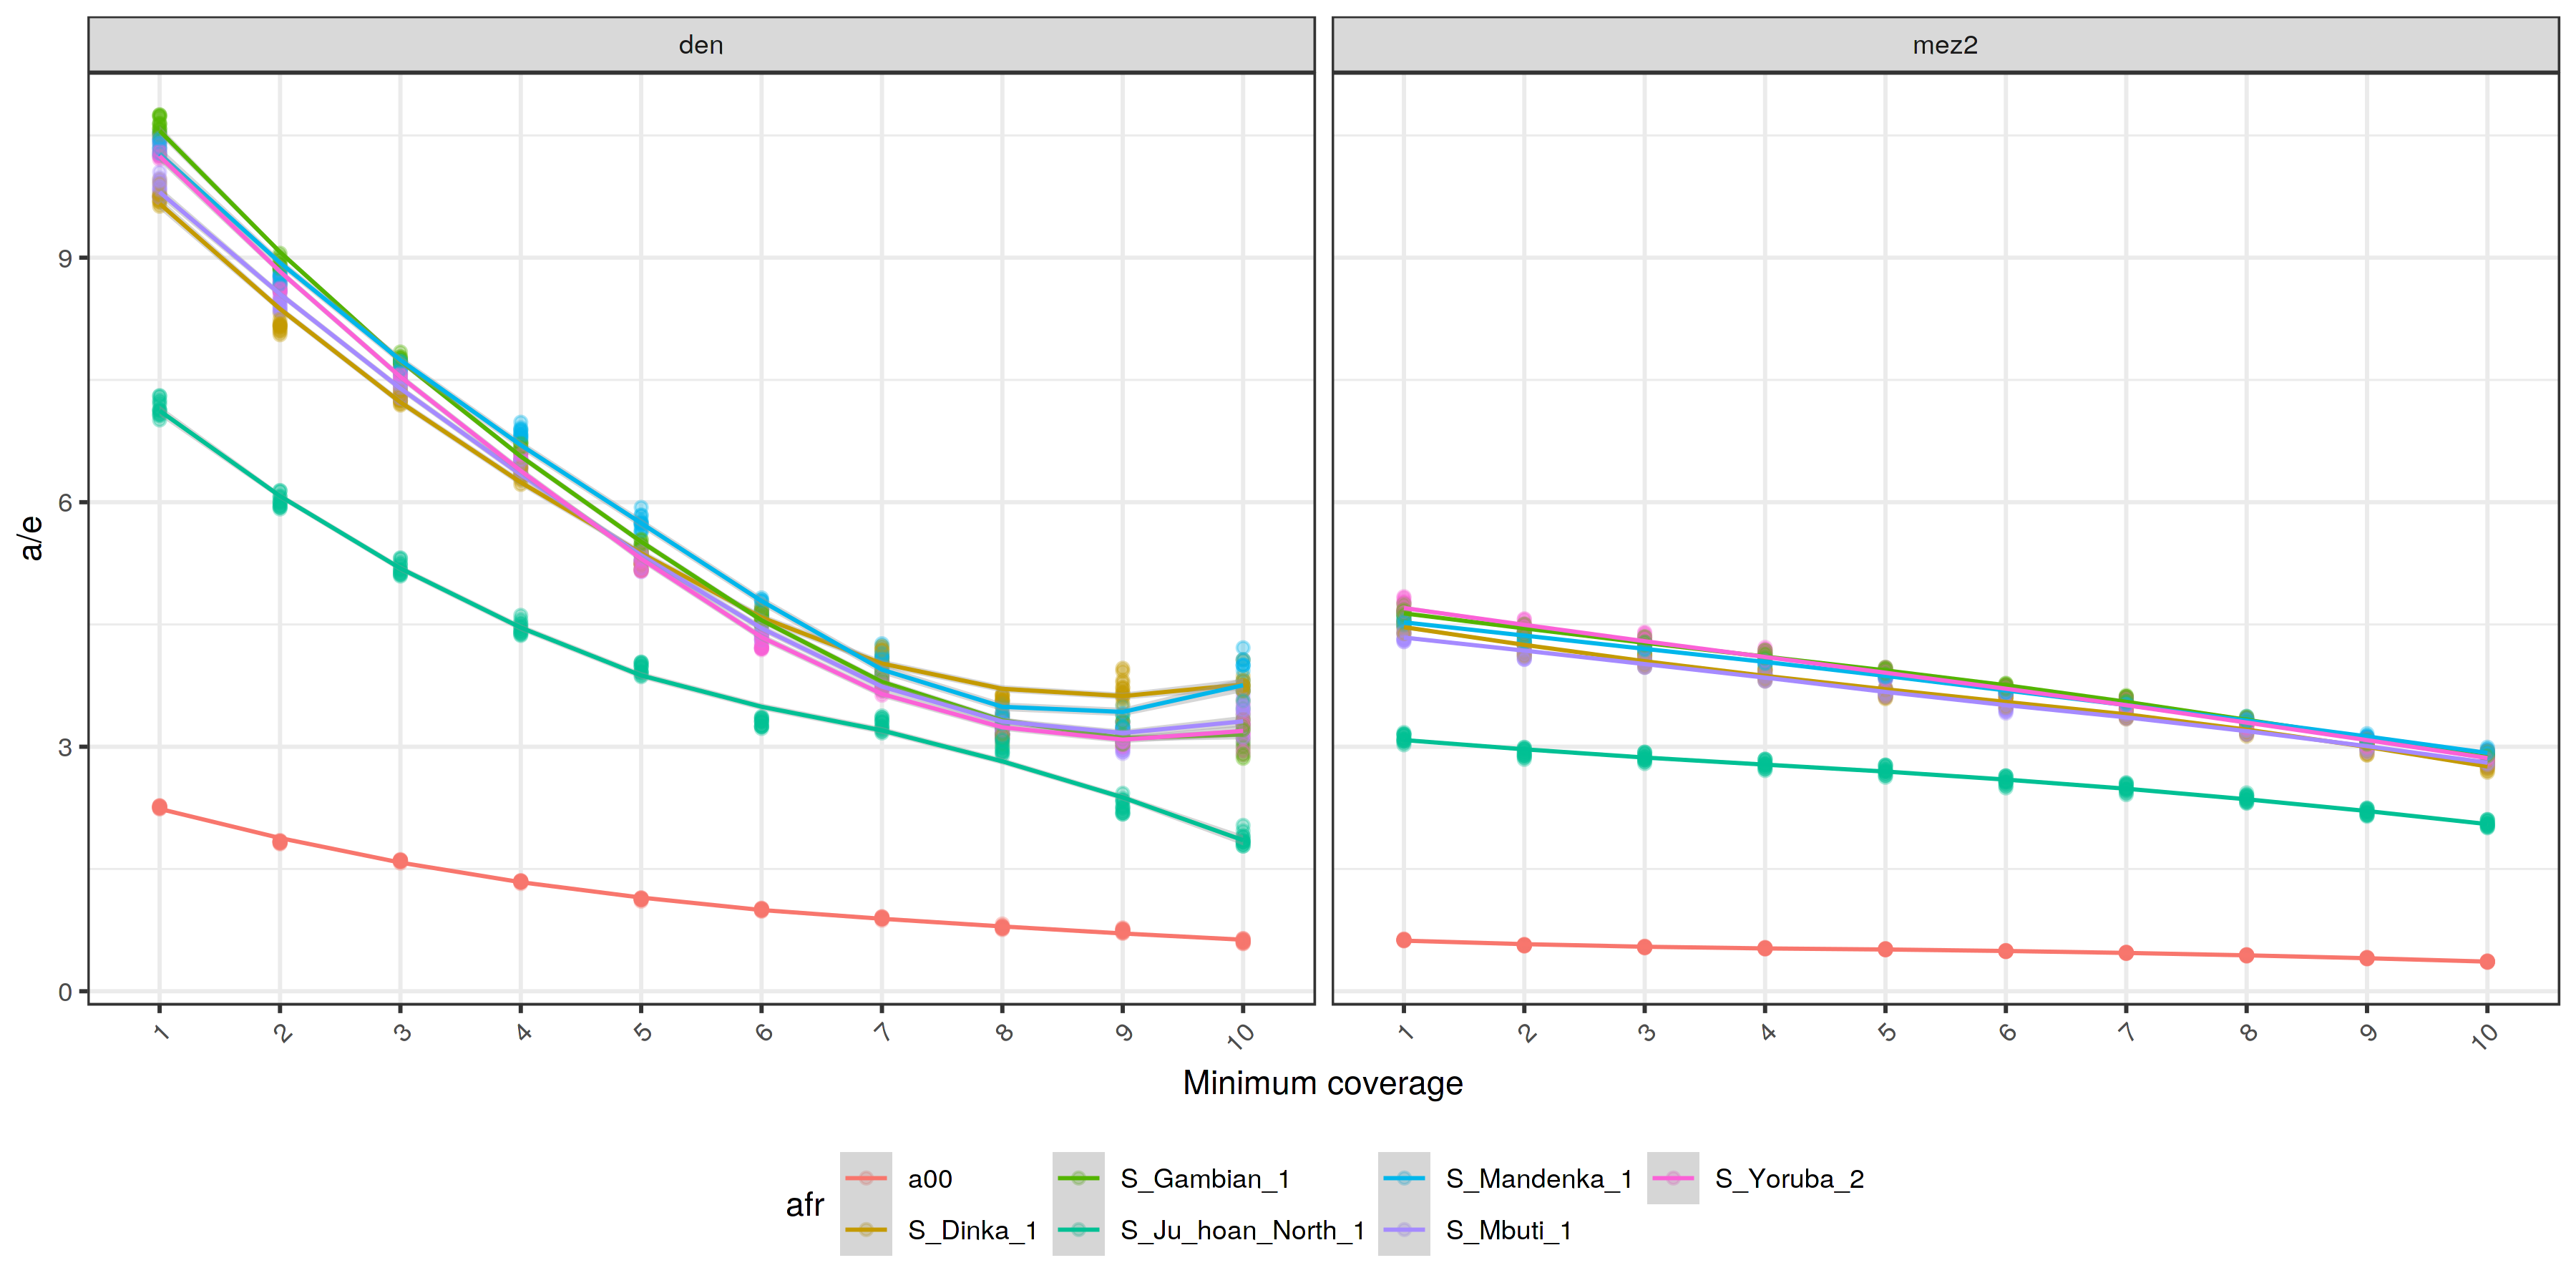

In [238]:
set_dim(12, 6)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(capture == "full", sites == "all", !arch %in% c("den8", "den4", "neand", "spy1")) %>% 
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts) %>%
ggplot(aes(as.factor(dp), a / e, color = afr)) +
    geom_point(alpha = 1/3) +
    geom_smooth(aes(group = afr), size = 0.5) +
    facet_wrap(arch ~ ., ncol = 6) +
    theme_bw() + xlab("Minimum coverage") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


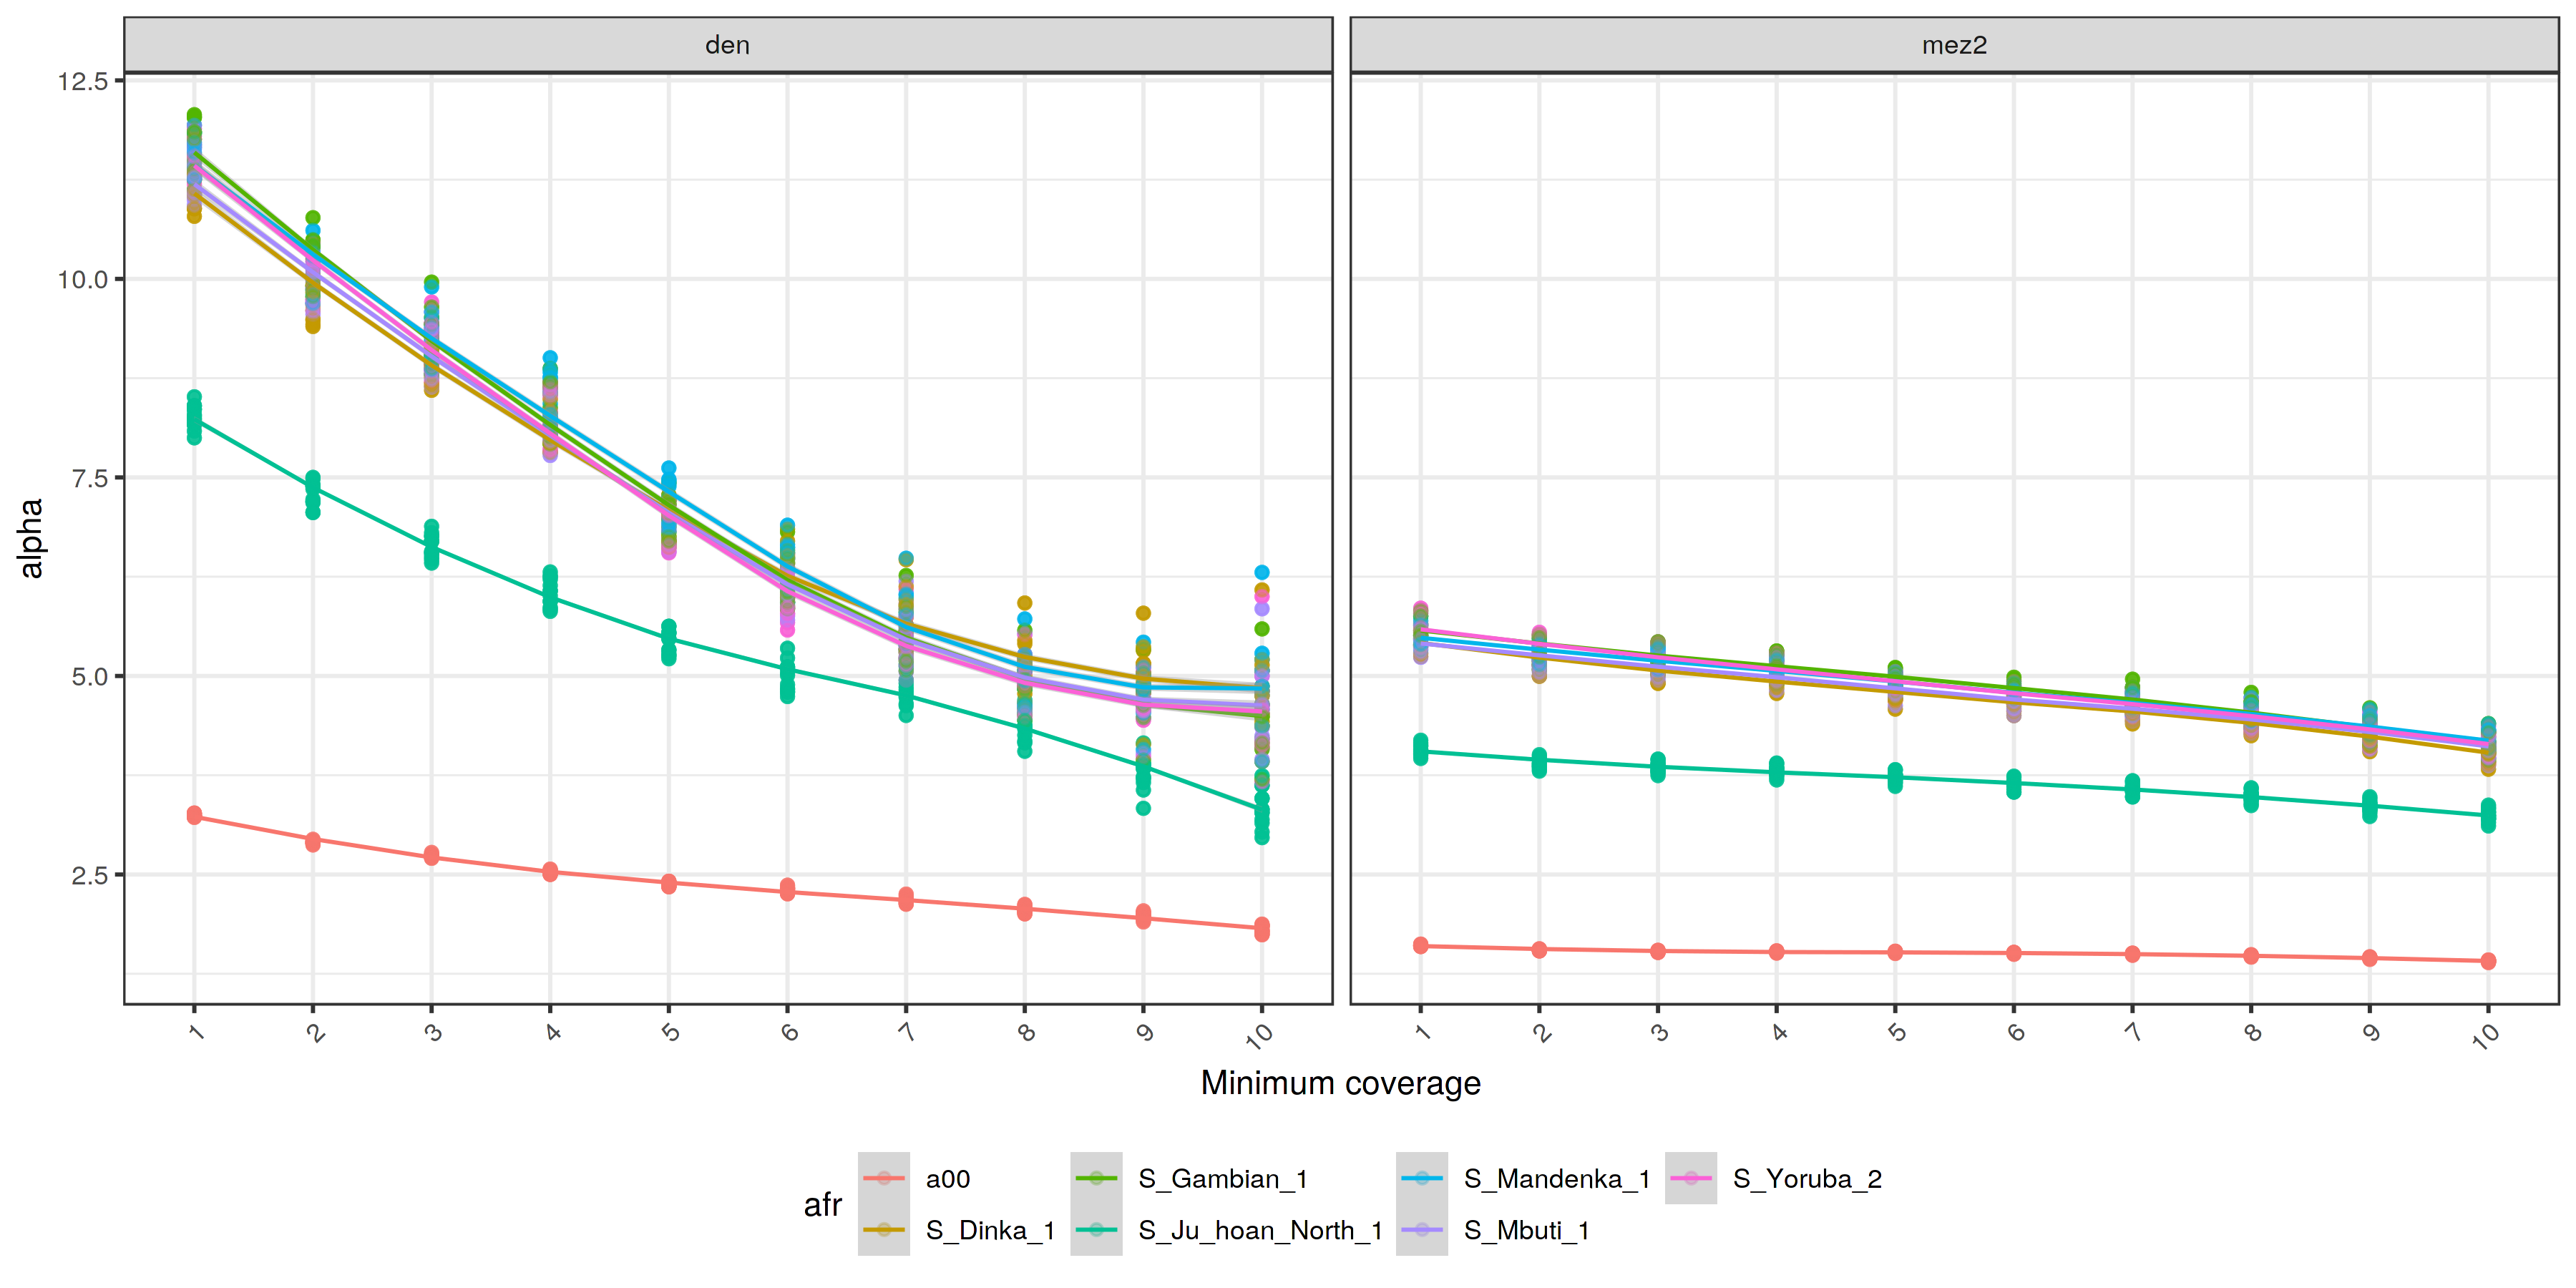

In [189]:
set_dim(12, 6)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(capture == "full", sites == "all", !arch %in% c("den8", "den4", "neand", "spy1")) %>% 
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts)) %>% 
mutate(prop = count / n_muts) %>%
ggplot(aes(as.factor(dp), alpha, color = afr)) +
    geom_point(alpha = 1/3) +
    geom_smooth(aes(group = afr), size = 0.5) +
    facet_wrap(arch ~ ., ncol = 6) +
    theme_bw() + xlab("Minimum coverage") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

points here:

1. 3X coverage seems to remove most of the error effects nicely - best argument for using this cutoff in the middle panel.
2. TV-only removes all erors (TMRCA doesn't change) => sequencing errors minimal beyond aDNA damage.
3. Minimal effect of reference bias with increasing coverage??? Based on the Neanderthal line in the center panel, but significant bias in Denisova?

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?